In [ ]:
# Senior Citizens Welfare Eligibility & Fraud detection system
this project stimulates a government welfare program design to support citizen
aged 60+ in Abia state, Nigeria.

Goals:
-Verify eligibility (Age + Residency)
- Detect Fraud (Duplicate biometric & bank accounts)
- Produce final approved beneficiaries list

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

In [ ]:
citizens = pd.read_csv("citizens.csv")
biometric = pd.read_csv("biometric.csv")
payment = pd.read_csv("payment.csv")

citizens.head()

In [ ]:
# Merge Datasets
df = citizens.merge(biometric, on="citizen_id")
df = df.merge(payment, on="citizen_id")

df.head()

In [ ]:
#Age Calculation
df["date_of_birth"] = pd.to_datetime(df["date_of_birth"])

today = datetime.today()
df["age"] = (today - df["date_of_birth"]).dt.days//365

#checking Eligibility
df["is_abia"] = df["state_of_origin"] == "Abia"
df["is_60_plus"] = df["age"] >= 60

In [ ]:
# For Duplicate fingerprint Check

df["duplicate_fingerprint"] = df.duplicated(subset=["fingerprint_hash"], keep=False)

#for duplicate bank account check
df["duplicate_bank"] = df.duplicated(subset=["bank_account"], keep=False)

#Fraud flag
df["fraud_flag"] = df["duplicate_fingerprint"] | df["duplicate_bank"]

df.head()

In [ ]:
#Final Eligibility Logic

df["eligible"] = (
    df["is_60_plus"] &
    df["is_abia"] &
    (~df["fraud_flag"])
)

df.head()

In [ ]:
#Approved List

approved = df[df["eligible"] == True]
approved.head()

In [ ]:
#Summary Statistics

print("Total_Applications:", len(df))
print("Eligible Citizens:", df["eligible"].sum())
print("Fraud Class Detected:", df["fraud_flag"].sum())

In [ ]:
approved.to_csv("approved_beneficiaries.csv", index=False)

In [ ]:
import streamlit as st
import pandas as pd

df = pd.read_csv("approved_beneficiaries.csv")
st.title("Senior Citizen Walfare Dashboard")
st.metric("Total Approved", len(df))
lga_counts = df["lga"].value_counts()
st.bar_chart(lga_counts)

In [ ]:
#Machine Learning Fraud detection

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [ ]:
#Creating numerical fraud features 

fraud_features = df.copy()

fraud_features["fingerprint_count"] = df.groupby("fingerprint_hash")["citizen_id"].transform("count")
fraud_features["bank_count"] = df.groupby("bank_account")["citizen_id"].transform("count")
fraud_features["age"] = ((pd.Timestamp("today") - pd.to_datetime(fraud_features["date_of_birth"])).dt.days // 365)


x = fraud_features[["age", "fingerprint_count", "bank_count"]]


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

In [ ]:
model = IsolationForest(contamination=0.05, random_state=42)
df["ml_fraud_prediction"] = model.fit_predict(X_scaled)

df["ml_fraud_flag"] = df["ml_fraud_prediction"] == -1

In [ ]:
df.head()

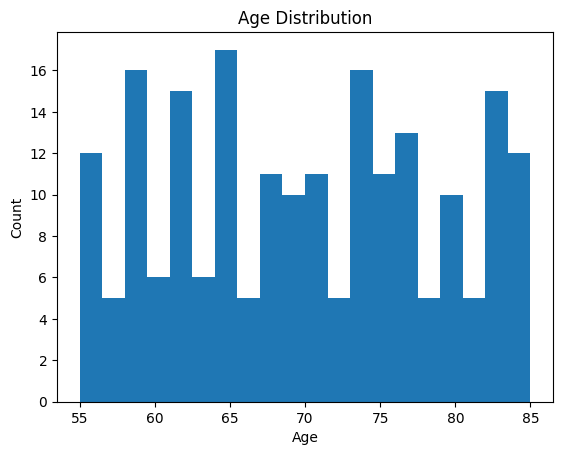

In [19]:
import matplotlib.pyplot as plt

plt.hist(df["age"], bins=20)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

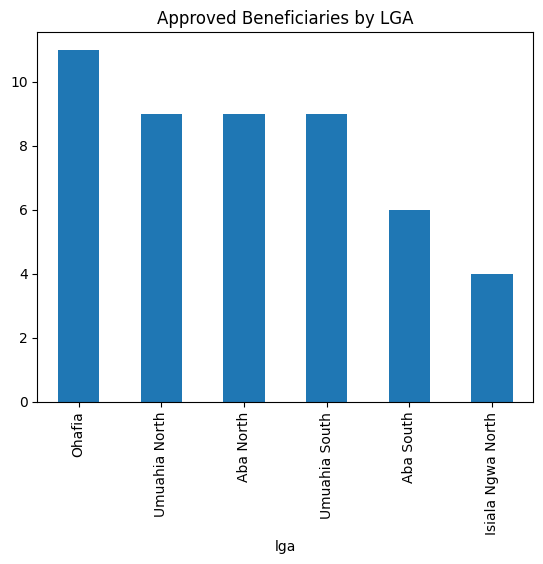

In [23]:
# Approved by LGA

approved_lga = df[df["eligible"] == True]["lga"].value_counts()

approved_lga.plot(kind="bar")
plt.title("Approved Beneficiaries by LGA")
plt.show()

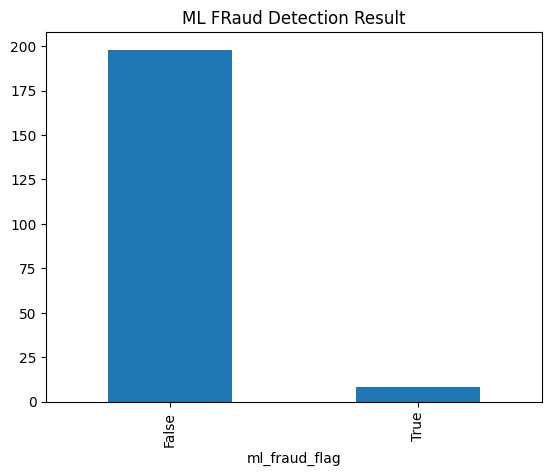

In [25]:
# Fraud Distribution

fraud_counts = df["ml_fraud_flag"].value_counts()

fraud_counts.plot(kind="bar")
plt.title("ML FRaud Detection Result")
plt.show()

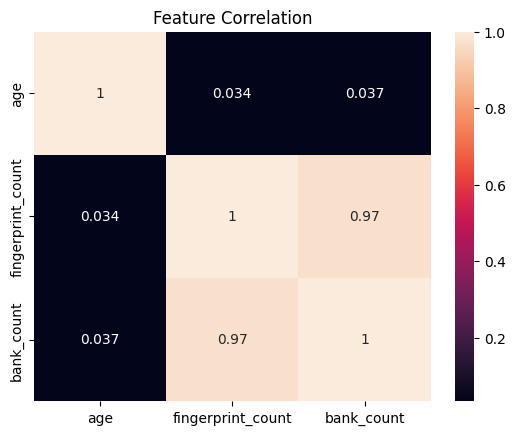

In [28]:
import seaborn as sns

corr = x.corr()
sns.heatmap(corr, annot=True)
plt.title("Feature Correlation")
plt.show()